In [1]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm

Looking in indexes: https://test.pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 re

In [2]:
import roboflow
import supervision
import transformers
import pytorch_lightning
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor
import supervision as sv

In [3]:
# settings
#CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

model = DetrForObjectDetection.from_pretrained("nicollecnunes/new-db")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
image_processor = DetrImageProcessor.from_pretrained("nicollecnunes/new-db")


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="lGLcf2NruK1PNW6iUqdg")
project = rf.workspace("objet-detect-yolov5").project("eep_detection-u9bbd")
dataset = project.version(1).download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to EEP_Detection-1 in coco:: 100%|██████████| 3243/3243 [00:01<00:00, 2058.84it/s]


In [ ]:
import os
import torchvision
# settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset.location, "train")
VAL_DIRECTORY = os.path.join(dataset.location, "valid")
TEST_DIRECTORY = os.path.join(dataset.location, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 2264
Number of validation examples: 647
Number of test examples: 324


In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

In [ ]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

# Mostrar o groundtruth e objetos preditos em uma imagem

Image #218
ground truth


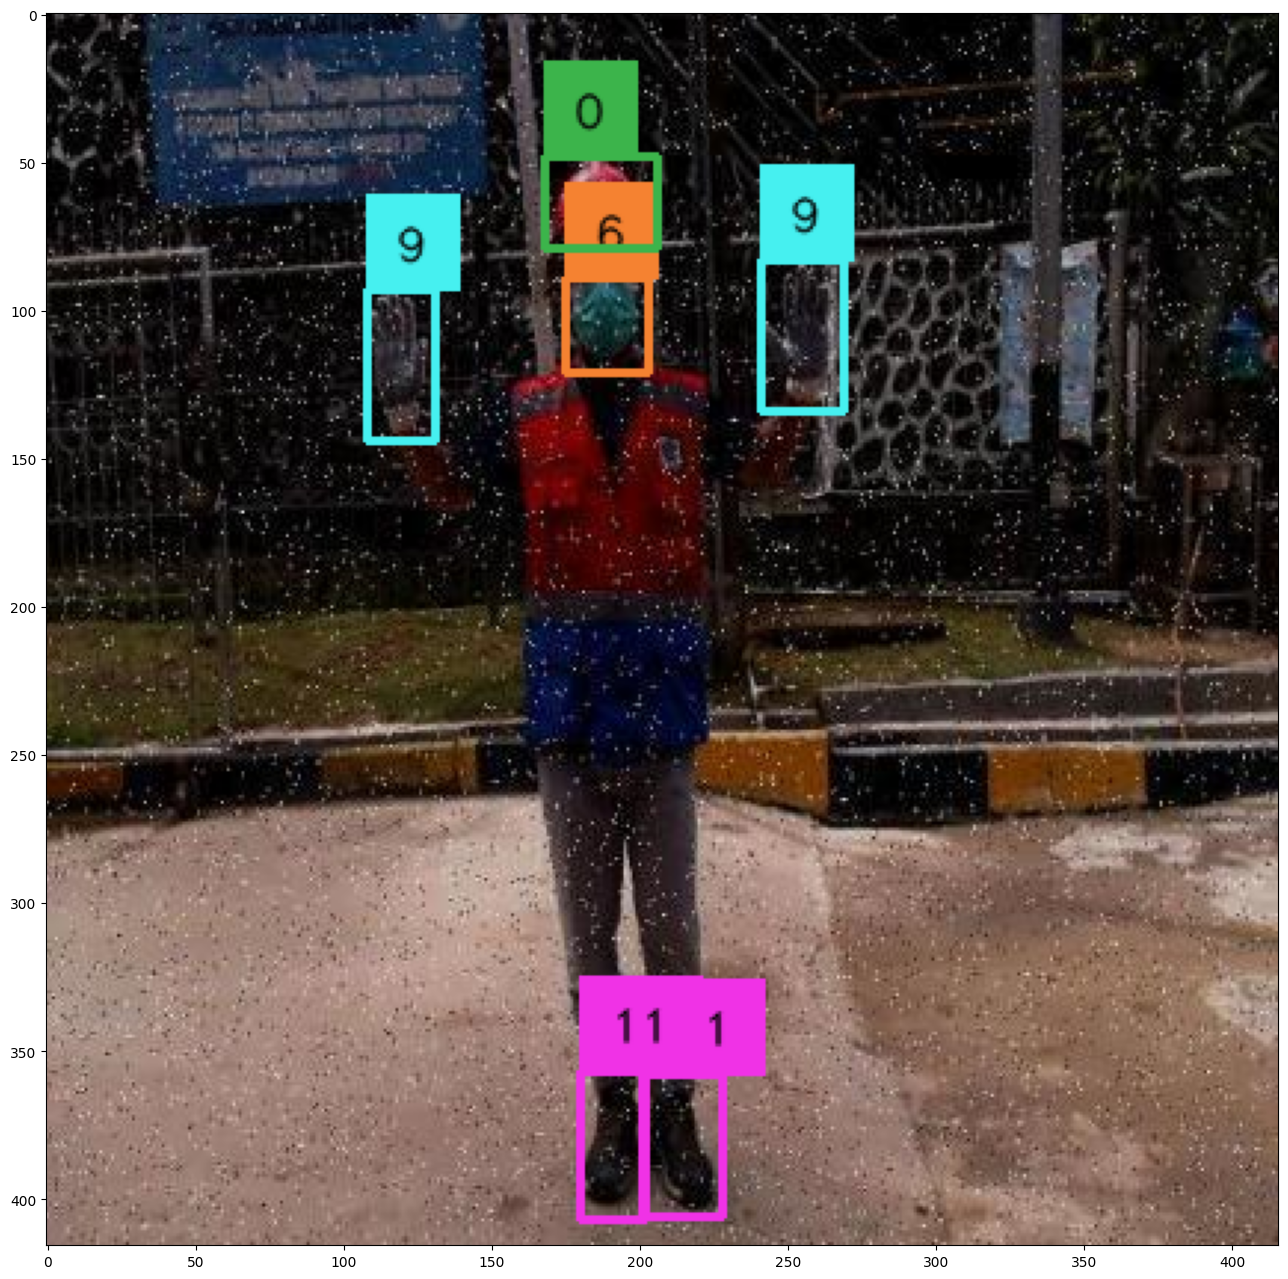

detections


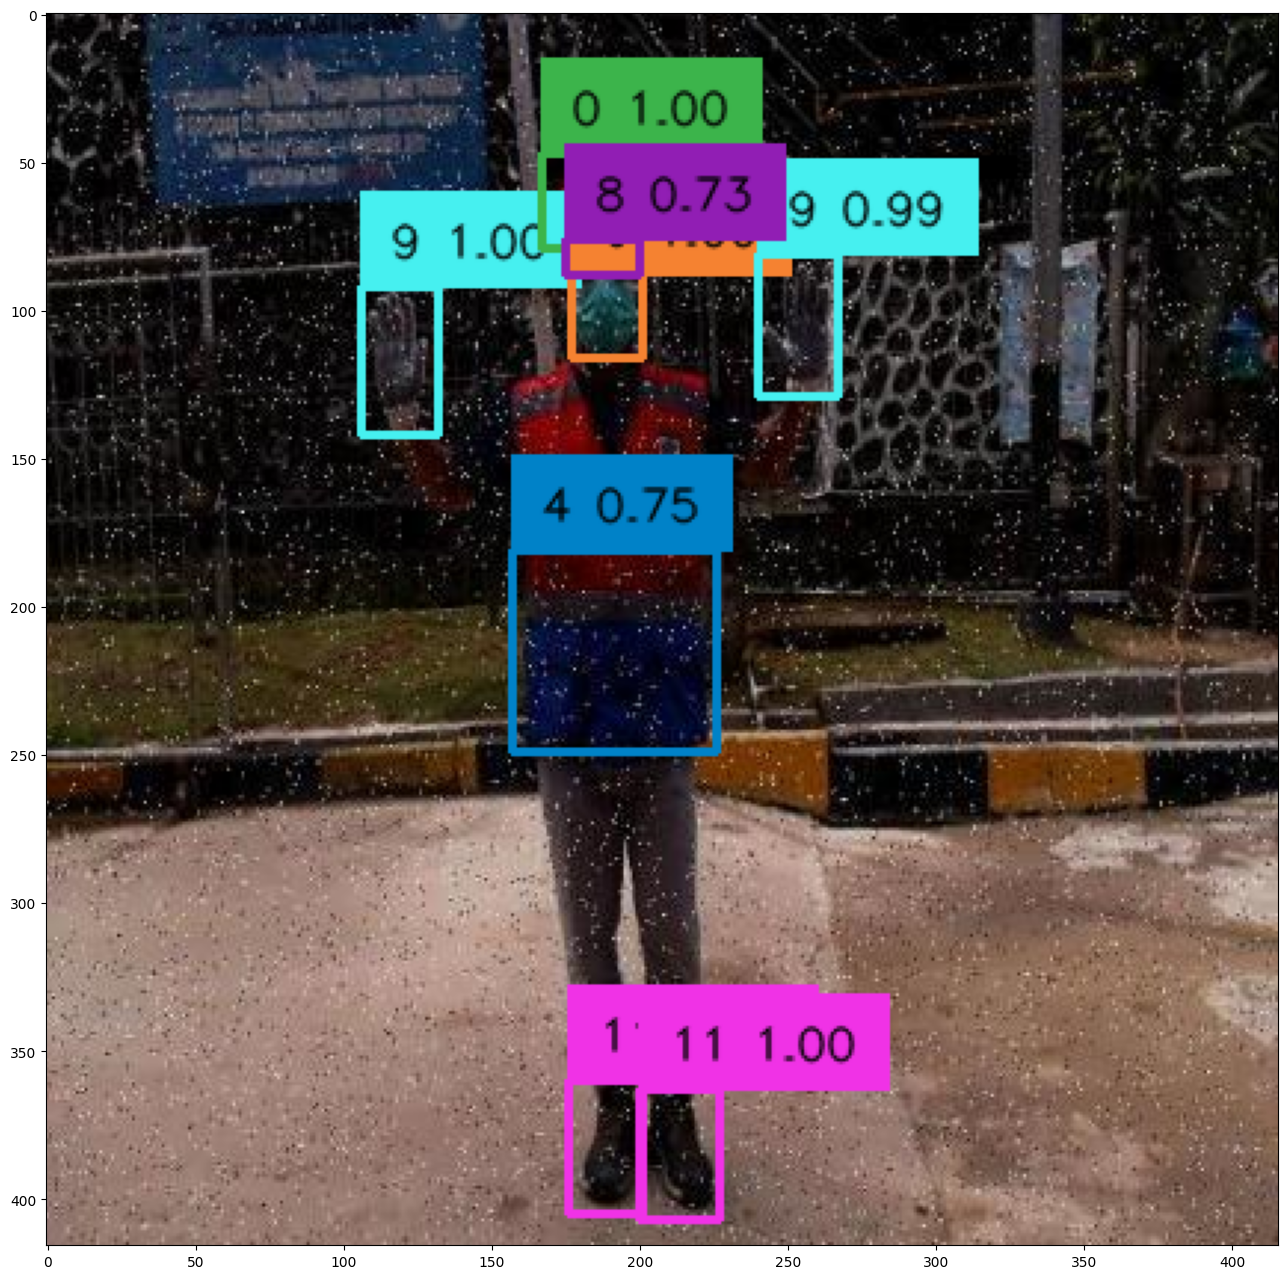

In [ ]:
import random
import cv2
import numpy as np


# utils
categories = VAL_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = VAL_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = VAL_DATASET.coco.loadImgs(image_id)[0]
annotations = VAL_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(VAL_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(device)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(device)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [ ]:
!pip install -q coco_eval

  Preparing metadata (setup.py) ... done


In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

# Calcula o MAP para o conjunto de TEST

In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=VAL_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate(tqdm(VAL_DATALOADER)):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/162 [00:00<?, ?it/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Accumulating evaluation results...
DONE (t=0.29s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.521
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.590
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.567
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.435
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.663
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [ ]:
import cv2
def detect_image(image_id, CONFIDENCE_TRESHOLD = 0.5):
    # load image and annotatons
    #image_id = 0
    image = VAL_DATASET.coco.loadImgs(image_id)[0]
    annotations = VAL_DATASET.coco.imgToAnns[image_id]
    image_path = os.path.join(VAL_DATASET.root, image['file_name'])
    image = cv2.imread(image_path)

    # ground truth
    # annotate
    detections_gt = sv.Detections.from_coco_annotations(coco_annotation=annotations)
    #print(f'detections_gt = {detections_gt}')
    labels_gt = [f"{id2label[class_id]}" for _, _, class_id, _ in detections_gt]
    #print(f'labels_gt = {labels_gt}')

    # predicted
    with torch.no_grad():

        # load image and predict
        inputs = image_processor(images=image, return_tensors='pt').to(device)
        outputs = model(**inputs)

        # post-process
        target_sizes = torch.tensor([image.shape[:2]]).to(device)
        results = image_processor.post_process_object_detection(
            outputs=outputs,
            threshold=CONFIDENCE_TRESHOLD,
            target_sizes=target_sizes
        )[0]

    # annotate
    #print(f'results = {results}')
    if len(results['scores']) == 0:
        detections_pd = []
    else:
        detections_pd = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
        #print(f'detections_pd = {detections_pd}')
        labels_pd = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections_pd]
        #print(f'labels_pd = {labels_pd}')
    return detections_pd, detections_gt

In [ ]:
def bb_intersection_over_union(boxP, boxG):
    if(len(boxP) == 0):
        print("vazio")
        return 0
	# determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxP[0], boxG[0])
    yA = max(boxP[1], boxG[1])
    xB = min(boxP[2], boxG[2])
    yB = min(boxP[3], boxG[3])
	# compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
    boxAArea = (boxP[2] - boxP[0] + 1) * (boxP[3] - boxP[1] + 1)
    boxBArea = (boxG[2] - boxG[0] + 1) * (boxG[3] - boxG[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
    return iou


In [ ]:
def iou_image(xyxy_pd, class_pd, xyxy_gt, class_gt, iou_thresh = 0.5, class_num = 8):
    class_match = np.zeros((class_num+1, class_num+1))
    background = class_num
    pos_iou = np.zeros((len(class_gt)))
    for i in range(len(class_pd)):
        iou = np.zeros((len(class_gt)))
        pos_iou = np.zeros((len(class_gt)))
        for j in range(len(class_gt)):
            iou[j] = bb_intersection_over_union(xyxy_pd[i,:], xyxy_gt[j,:])
        max_id = np.argmax(iou)
        #print(iou)
        if iou[max_id] >= iou_thresh:
            class_match[class_gt[max_id], class_pd[i]] += 1
            pos_iou[max_id] = 1
            #print(f'[{class_gt[max_id]}][{class_pd[i]}]')
        else:
            class_match[[background], class_pd[i]] += 1
    ind = pos_iou == 1
    #print(pos_iou)
    for gt_label in class_gt[ind]:
        class_match[gt_label][background] += 1
    return class_match


In [ ]:
import numpy as np

In [ ]:
xyxy_pd = np.array([[174.4823  ,  94.34152 , 210.76262 , 124.24295 ],
       [236.43306 , 277.36304 , 257.2021  , 340.2634  ],
       [169.2327  ,   6.906256, 225.41833 ,  65.266846],
       [122.89927 , 289.67365 , 151.1001  , 349.19666 ],
       [172.55292 ,  64.56171 , 214.268   ,  82.69814 ],
       [136.79771 , 178.25696 , 238.92717 , 272.99792 ]])
xyxy_gt = np.array([[177,  86, 214, 124],
       [141, 174, 241, 279],
       [100, 300, 258, 338],
       [124, 278, 153, 350],
       [172,   9, 224,  65],
       [178,  59, 217,  80]])
class_pd = np.array([4, 6, 1, 6, 5, 3])
class_gt = np.array([4, 3, 6, 2, 1, 5])

In [ ]:
print(iou_image(xyxy_pd, class_pd, xyxy_gt, class_gt))

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]]


## Calculo da matriz de confusão

In [ ]:
def confusion_matrix(class_num):
    class_match = np.zeros((class_num+1, class_num+1))
    i = 0
    image_ids = VAL_DATASET.coco.getImgIds()
    for i, img_id in enumerate(image_ids):
        if (i % 10 == 0):
          print(f'{i}/{len(VAL_DATASET)}')
        detections_pd, detections_gt = detect_image(img_id, CONFIDENCE_TRESHOLD = 0.5)
        if len(detections_pd) == 0:
            continue
        matriz_tmp = iou_image(detections_pd.xyxy, detections_pd.class_id, detections_gt.xyxy, detections_gt.class_id, iou_thresh = 0.5, class_num = class_num)
        #print(matriz_tmp)
        class_match += matriz_tmp
        i += 1
    return class_match[1:,1:]

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

matriz = confusion_matrix(class_num=8)


0/647
10/647
20/647
30/647
40/647
50/647
60/647
70/647
80/647
90/647
100/647
110/647
120/647
130/647
140/647
150/647
160/647
170/647
180/647
190/647
200/647
210/647
220/647
230/647
240/647
250/647
260/647
270/647
280/647
290/647
300/647
310/647
320/647
330/647
340/647
350/647
360/647
370/647
380/647
390/647
400/647
410/647
420/647
430/647
440/647
450/647
460/647
470/647
480/647
490/647
500/647
510/647
520/647
530/647
540/647
550/647
560/647
570/647
580/647
590/647
600/647
610/647
620/647
630/647
640/647


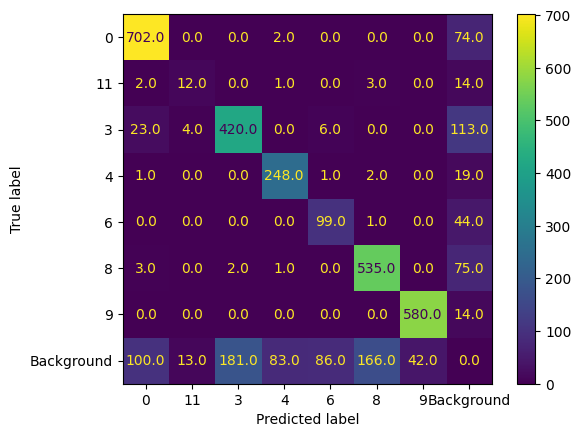

In [ ]:

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['0', '11', '3', '4', '6','8', '9','Background'])
disp.plot(values_format='')
plt.show()

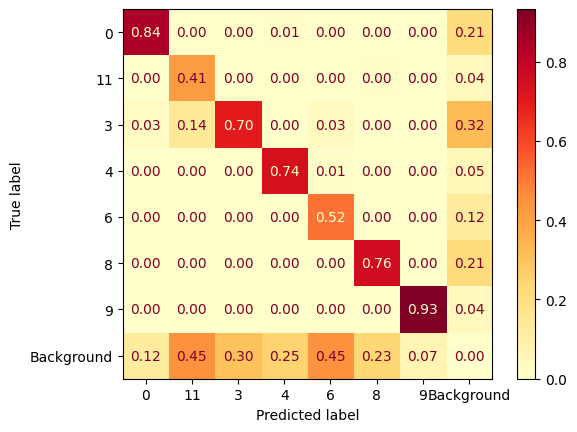

In [ ]:
tot = np.sum(matriz, axis=0, keepdims=True)
np.set_printoptions(precision=2)
m_porc = matriz/tot
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=['0', '11', '3', '4', '6','8', '9','Background'])
disp.plot(values_format='.2f', cmap='YlOrRd')
plt.show()

In [ ]:
print(m_porc)

[[0.9  0.   0.   0.   0.   0.   0.   0.1 ]
 [0.06 0.38 0.   0.03 0.   0.09 0.   0.44]
 [0.04 0.01 0.74 0.   0.01 0.   0.   0.2 ]
 [0.   0.   0.   0.92 0.   0.01 0.   0.07]
 [0.   0.   0.   0.   0.69 0.01 0.   0.31]
 [0.   0.   0.   0.   0.   0.87 0.   0.12]
 [0.   0.   0.   0.   0.   0.   0.98 0.02]
 [0.15 0.02 0.27 0.12 0.13 0.25 0.06 0.  ]]


In [5]:
matrixyolo = np.array([[745, 0., 0., 0., 0., 0., 0., 36],
                       [1, 14, 0., 0., 0., 0., 0., 1],
                       [1, 0, 532, 0., 0, 2., 0., 96],
                       [0., 0., 0., 299, 0., 0, 0., 25],
                       [0., 0., 6, 0., 126, 1, 0., 35],
                       [1., 0., 0., 0., 0., 590, 0., 29],
                       [0., 0., 0., 0., 0., 0., 289, 22],
                       [17, 11, 42, 15, 23, 52, 7, 0]])

totyolo = np.sum(matrixyolo, axis=0, keepdims=True)
np.set_printoptions(precision=2)
m_porcyolo = matrixyolo/totyolo
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porcyolo, display_labels=['0', '11', '3', '4', '6','8', '9','Background'])
disp.plot(values_format='.2f', cmap='YlOrRd')
plt.show()

NameError: name 'np' is not defined

In [ ]:
print(m_porcyolo)

[[0.95 0.   0.   0.   0.   0.   0.   0.05]
 [0.06 0.88 0.   0.   0.   0.   0.   0.06]
 [0.   0.   0.84 0.   0.   0.   0.   0.15]
 [0.   0.   0.   0.92 0.   0.   0.   0.08]
 [0.   0.   0.04 0.   0.75 0.01 0.   0.21]
 [0.   0.   0.   0.   0.   0.95 0.   0.05]
 [0.   0.   0.   0.   0.   0.   0.93 0.07]
 [0.1  0.07 0.25 0.09 0.14 0.31 0.04 0.  ]]


In [1]:
import numpy as np
matrixyolo = np.array([[745, 0., 0., 0., 0., 0., 0., 36],
                       [1, 14, 0., 0., 0., 0., 0., 1],
                       [1, 0, 532, 0., 0, 2., 0., 96],
                       [0., 0., 0., 299, 0., 0, 0., 25],
                       [0., 0., 6, 0., 126, 1, 0., 35],
                       [1., 0., 0., 0., 0., 590, 0., 29],
                       [0., 0., 0., 0., 0., 0., 289, 22],
                       [17, 11, 42, 15, 23, 52, 7, 0]])
print(matrixyolo)

[[745.   0.   0.   0.   0.   0.   0.  36.]
 [  1.  14.   0.   0.   0.   0.   0.   1.]
 [  1.   0. 532.   0.   0.   2.   0.  96.]
 [  0.   0.   0. 299.   0.   0.   0.  25.]
 [  0.   0.   6.   0. 126.   1.   0.  35.]
 [  1.   0.   0.   0.   0. 590.   0.  29.]
 [  0.   0.   0.   0.   0.   0. 289.  22.]
 [ 17.  11.  42.  15.  23.  52.   7.   0.]]


In [6]:
def prec_recall(matriz):
    tot_coluna = np.sum(matriz, axis=0)
    tot_linha = np.sum(matriz, axis=1)
    d = np.diag(matriz)
    recall = d / tot_linha
    prec = d / tot_coluna
    return prec, recall

In [5]:
print(np.diag(matrixyolo))
print( np.sum(matrixyolo, axis=0) )

[745.  14. 532. 299. 126. 590. 289.   0.]
[765.  25. 580. 314. 149. 645. 296. 244.]


In [9]:
p,r = prec_recall(matrixyolo)
print( f'precision : {np.mean(p[:-1])}' )
print( f'recall : {np.mean(r[:-1])}' )

precision : 0.8771492150340343
recall : 0.8893891842721321


In [10]:
def prec_recall_micro(matriz):
    tot_coluna = np.sum(matriz, axis=0)
    tot_linha = np.sum(matriz, axis=1)
    d = np.diag(matriz)
    recall = np.sum(d[:-1]) / np.sum(tot_linha[:-1])
    prec = np.sum(d[:-1]) / np.sum(tot_coluna[:-1])
    return prec, recall

In [11]:
p,r = prec_recall_micro(matrixyolo)
print( f'precision : {p}' )
print( f'recall : {r}' )

precision : 0.9354722422494592
recall : 0.9102069449316029
